In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

import scipy.linalg as spl

# Function for testing positive definiteness
def is_pos_def(A):
    if np.allclose(A, A.conj().T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

comment = "Fit to covariance in sim"
nb_name = "nb_midpath_dynamo_covmod_sim"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)
core.generate_map(target_var_factor = 1)

core.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

In [3]:
core.semivar(model_lags = 20, model = "exponential", max_dist = 20000, lag_length = 100,
             zero_nugget = True, hit_target_var = False)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 100.0 km
Number of lags: 109
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


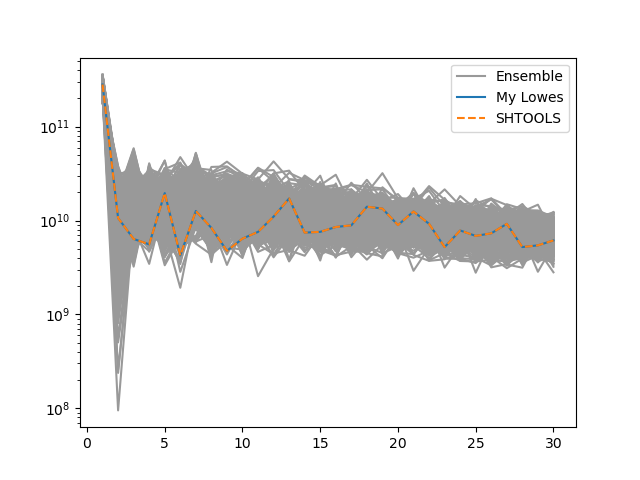

In [4]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

# g ensemble and parameters
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9
g_core_ens = g_core_ens[:mt_util.shc_vec_len(shc_g),:]

a = core.a
c = core.r_cmb
n_max = shc_g

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g
R = mt_util.lowe_shspec(n_max,c,a,g_cut)

# One spectra for comparison to SHTOOLS
g_cut_one = g_core_ens[:,core.ens_idx][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

# SHTOOLS
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))
p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

# Spectra
plt.figure()
for i in np.arange(R.shape[1]):
    if i == 0:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6),label="Ensemble")
    else:
        plt.semilogy(np.arange(1,n_max+1),R[:,i],color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one,label="My Lowes")
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed", label="SHTOOLS")
plt.legend()
plt.show()

# New tapered cov

[]


<IPython.core.display.Javascript object>


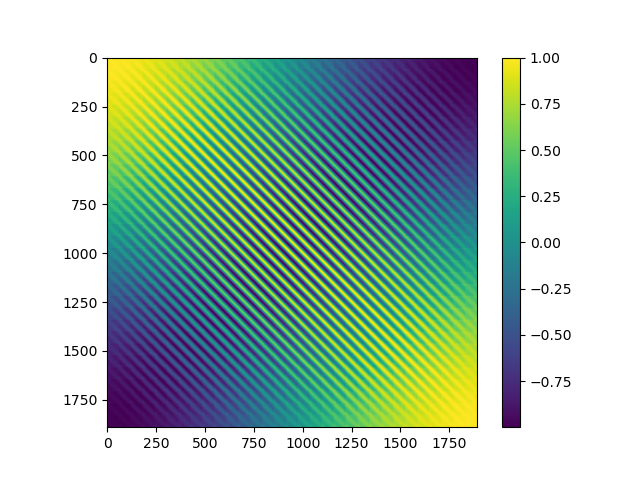

In [5]:
c_angdist = np.cos(mt_util.haversine(1, core.grid_phi.reshape(1,-1), 90-core.grid_theta.reshape(1,-1), 
                              core.grid_phi.reshape(-1,1), 90-core.grid_theta.reshape(-1,1)))

print(c_angdist[c_angdist>1])

plt.figure()
plt.imshow(c_angdist)
plt.colorbar()
plt.show()

In [57]:
tap_to = 500
n_tap = n_max + tap_to

tap_cos = np.cos(np.linspace(0,np.pi,20))+1
tap_cos_norm = ((tap_cos - np.min(tap_cos))/(np.max(tap_cos)-np.min(tap_cos))).reshape(-1,1)

# Compute covariances based on eqn. 11
C_const = (np.arange(1,n_tap+1)+1)/(2*np.arange(1,n_tap+1)+1)

# Pn
Pn = []
for cmu in np.ravel(c_angdist):
    Pn.append(pyshtools.legendre.PlSchmidt(n_tap,cmu)[1:].reshape(-1,1))

Pn = np.array(Pn).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

# Automate pos def find

<IPython.core.display.Javascript object>


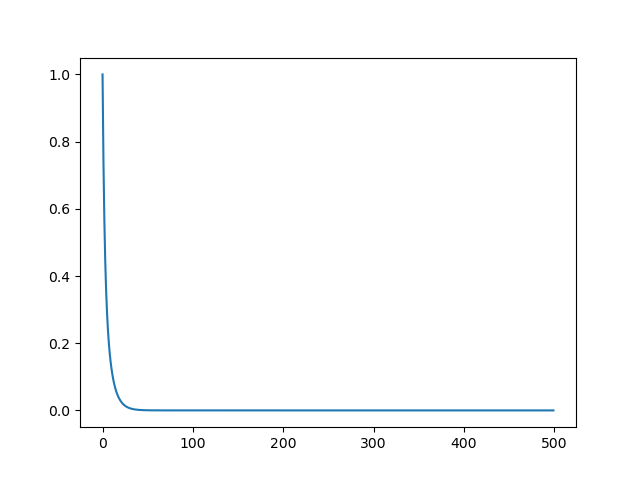

In [80]:
#tap_to = 500

lin_exp = np.linspace(0,24,tap_to)

tap_exp = 0.5*np.exp(-10*lin_exp) + 0.5*np.exp(-3*lin_exp)


plt.figure()
plt.plot(tap_exp)
plt.show()

In [64]:
init_lin = 40
N_lin = 6
tap_fac = 25

<IPython.core.display.Javascript object>


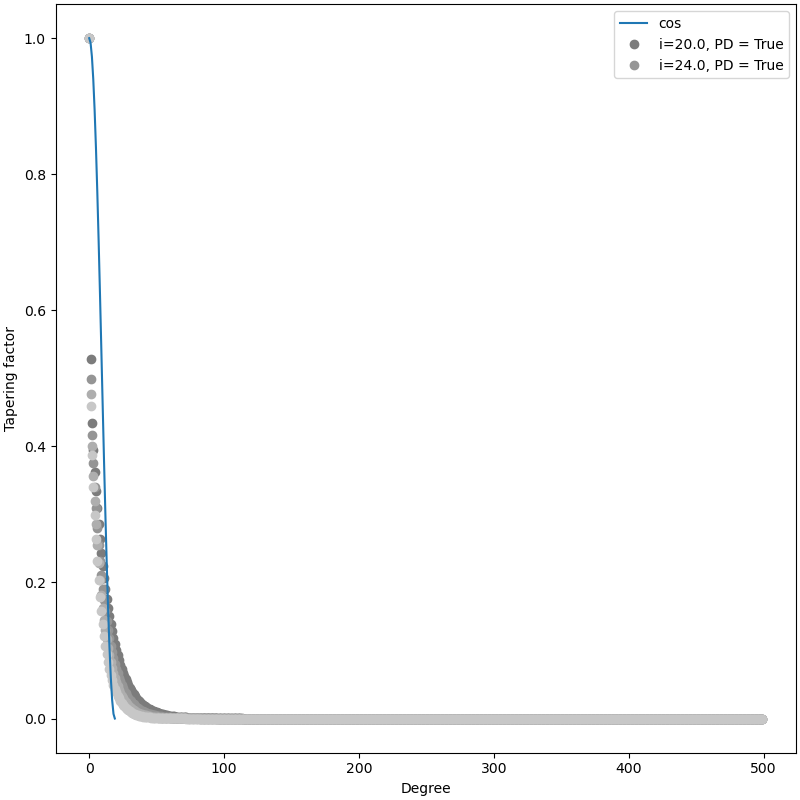

KeyboardInterrupt: 

In [82]:
fig = plt.figure(figsize=(8,8), constrained_layout=True)
gs = fig.add_gridspec(1, 1) 
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(tap_cos_norm,label="cos",zorder=1)
legend_list = ["cos"]
ax1.legend(legend_list)
ax1.set_xlabel('Degree')
ax1.set_ylabel('Tapering factor')
fig.canvas.draw()

#try_lin = np.flip(np.round(np.linspace(3,init_lin,N_lin),decimals=2))
try_lin = np.round(np.linspace(20,init_lin,N_lin),decimals=2)

for i in try_lin:
    #lin_tanh = np.linspace(3,i,tap_to)
    #tap_tanh = -(np.exp(tap_fac*lin_tanh)-np.exp(-tap_fac*lin_tanh))/(np.exp(tap_fac*lin_tanh)+np.exp(-tap_fac*lin_tanh))
    #tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)
    
    lin_exp = np.linspace(0,i,tap_to)
    #tap_exp = np.exp(-tap_fac**lin_exp).reshape(-1,1)
    tap_exp = (0.5*np.exp(-50*lin_exp) + 0.5*np.exp(-2*lin_exp)).reshape(-1,1)
    
    #R_add = R[-1,:]*tap_tanh_norm
    R_add = R[-1,:]*tap_exp
    R_tap = np.vstack((R,R_add))

    C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

    C_Br_model = C_Br[:,:,core.ens_idx]
    
    PD = is_pos_def(C_Br_model)
    
    # update plot
    #ax1.plot(tap_tanh_norm, 'o', color = (i/(init_lin+1),i/(init_lin+1),i/(init_lin+1)),zorder=0)
    ax1.plot(tap_exp, 'o', color = (i/(init_lin+1),i/(init_lin+1),i/(init_lin+1)),zorder=0)
    if PD:
        legend_list.append('i={}, PD = {}'.format(np.round(i,decimals=2),PD))
    ax1.legend(legend_list)
    
    fig.canvas.draw()
    time.sleep(0.01)

<IPython.core.display.Javascript object>


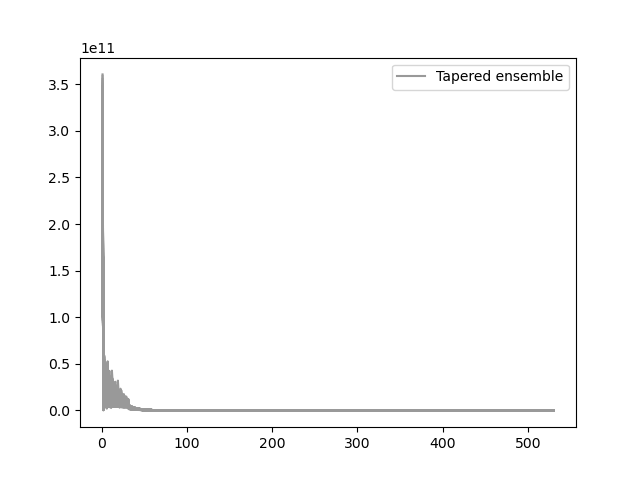

PD:  True


In [100]:
#lin_tanh = np.linspace(3,7,tap_to)
#tap_tanh = -(np.exp(tap_fac*lin_tanh)-np.exp(-tap_fac*lin_tanh))/(np.exp(tap_fac*lin_tanh)+np.exp(-tap_fac*lin_tanh))
#tap_tanh_norm = ((tap_tanh - np.min(tap_tanh))/(np.max(tap_tanh)-np.min(tap_tanh))).reshape(-1,1)

lin_exp = np.linspace(0,24,tap_to)
#tap_exp = np.exp(-tap_fac*lin_exp).reshape(-1,1)
tap_exp = (0.5*np.exp(-100*lin_exp) + 0.5*np.exp(-2*lin_exp)).reshape(-1,1)

#R_add = R[-1,:]*tap_tanh_norm
R_add = R[-1,:]*tap_exp
#R_add = np.ones((R[-1,:].shape))*tap_tanh_norm
R_tap = np.vstack((R,R_add))

# Spectra
plt.figure()
for i in np.arange(R_tap.shape[1]):
    if i == 0:
        #plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
        plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6),label="Tapered ensemble")
    else:
        #plt.semilogy(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
        plt.plot(np.arange(1,n_tap+1),R_tap[:,i],color=(0.6,0.6,0.6))
plt.legend()
plt.show()

C_Br = Pn@(C_const.reshape(-1,1)*R_tap)

C_Br_model = C_Br[:,:,core.ens_idx]

PD = is_pos_def(C_Br_model)
print("PD: ", PD)

In [98]:
i_C_Br_max = np.argmax(np.abs(C_Br),axis=2)

i_C_Br_max.shape

(1891, 1891)

In [99]:
C_Br_max = []

j = 0
for i in np.ravel(i_C_Br_max):
    C_Br_max.append(C_Br.reshape(-1,487)[j,i])
    j +=1
    
C_Br_model = np.array(C_Br_max).reshape(1891,1891)

In [84]:
C_Br_model = np.mean(C_Br,axis=2)

<IPython.core.display.Javascript object>


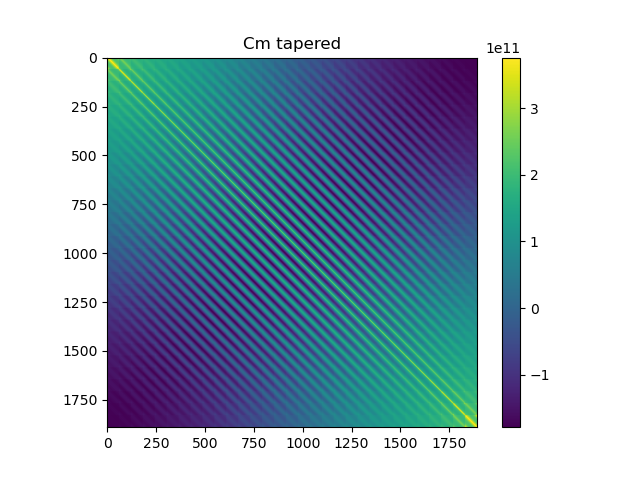

C_Br_model is pos def: True
All eigenvalues > 0: True
Number of negative eigenvalues: 0 / 1891


<IPython.core.display.Javascript object>


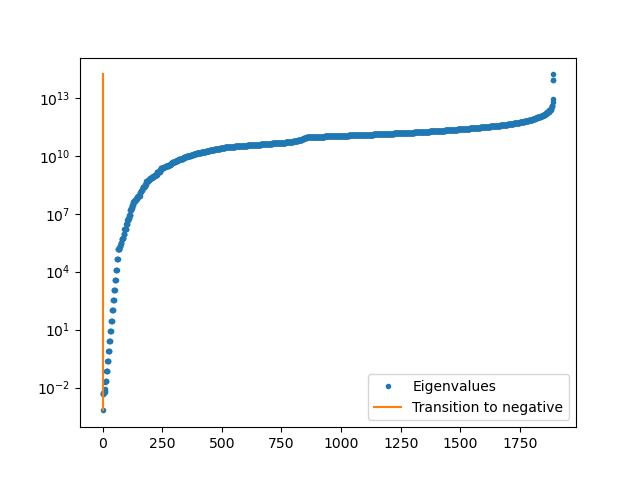

In [85]:
plt.figure()
plt.title("Cm tapered")
plt.imshow(C_Br_model)
plt.colorbar()
plt.show()

# Positive definite covariance?
core_eigval = spl.eigh(C_Br_model, eigvals_only=True)
N_neg_eigval = len(core_eigval[core_eigval<=0])
print("C_Br_model is pos def:", is_pos_def(C_Br_model))
print("All eigenvalues > 0:", np.all(core_eigval>=0))
print("Number of negative eigenvalues:",N_neg_eigval,"/",len(core_eigval))

plt.figure()
plt.semilogy(np.arange(0,len(core_eigval)),core_eigval,'.',label="Eigenvalues")
plt.semilogy(np.ones((100,))*N_neg_eigval,np.linspace(core_eigval[N_neg_eigval],core_eigval[-1],100),label="Transition to negative")
plt.legend()
plt.show()

# Synthetic sat

In [86]:
C_e_const = 2.0

s_sat = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)

s_sat.generate_map(grid_type = "swarm")

s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Source truth

In [87]:
s_source = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_source.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([s_source.grid_phi, 90-s_source.grid_theta]).T
s_source.make_grid(s_source.r_cmb, grid_in, calc_sph_d = False)

s_source.generate_map()

# System equations

In [88]:
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = C_Br_model)

# SDSSIM

 |----------| 6.8%   realization nr. 0. Counter: 128/1891, Running error magnitude: 5.7

 |O---------| 11.8%   realization nr. 0. Counter: 224/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 49.971 seconds 
Total elapsed time: 0.833 minutes 
Variance: 176059749471.923
Mean: 28571.796
Max: 2123178.809
Min: -1752112.387
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 49.451 seconds 
Total elapsed time: 1.657 minutes 
Variance: 254068418628.940
Mean: -33540.721
Max: 1453652.497
Min: -3013078.079
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 48.927 seconds 
Total elapsed time: 2.472 minutes 
Variance: 183036308472.440
Mean: -20032.204
Max: 2865611.360
Min: -1559780.932
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 48.708 seconds 
Total elapsed time: 3.284 minutes 
Variance: 335696068835.814
Mean: -4348.708
Max: 2860531.957
Min: -4193289.657
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realiza

 |----------| 6.8%   realization nr. 34. Counter: 128/1891, Running error magnitude: 5.8

 |O---------| 13.3%   realization nr. 34. Counter: 251/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 48.726 seconds 
Total elapsed time: 28.513 minutes 
Variance: 472569288040.685
Mean: 38448.777
Max: 3520004.989
Min: -3805464.299
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 48.762 seconds 
Total elapsed time: 29.326 minutes 
Variance: 207744997153.711
Mean: 889.196
Max: 1516042.913
Min: -2320015.277
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 48.878 seconds 
Total elapsed time: 30.141 minutes 
Variance: 268546917741.070
Mean: -23111.908
Max: 1456660.948
Min: -1620617.317
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 48.398 seconds 
Total elapsed time: 30.947 minutes 
Variance: 267880833584.398
Mean: -22215.363
Max: 2845443.307
Min: -2017476.523
Run nr.: 38

 |OOOOOOOOOO| 100.0%

 |----------| 6.3%   realization nr. 68. Counter: 119/1891, Running error magnitude: 5.6

 |O---------| 12.9%   realization nr. 68. Counter: 243/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 48.889 seconds 
Total elapsed time: 56.095 minutes 
Variance: 183558643495.780
Mean: 19718.408
Max: 3039250.993
Min: -1711348.788
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 48.575 seconds 
Total elapsed time: 56.905 minutes 
Variance: 291912522990.295
Mean: 3987.726
Max: 1892670.077
Min: -4023913.882
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 48.928 seconds 
Total elapsed time: 57.720 minutes 
Variance: 220536937487.682
Mean: -26619.318
Max: 3166535.402
Min: -1583425.146
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 48.614 seconds 
Total elapsed time: 58.530 minutes 
Variance: 213273716839.506
Mean: -64805.006
Max: 1442616.234
Min: -1454318.102
Run nr.: 72

 |OOOOOOOOOO| 100.0

 |----------| 8.0%   realization nr. 102. Counter: 151/1891, Running error magnitude: 5.7

 |O---------| 13.6%   realization nr. 102. Counter: 258/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 102. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.181 seconds 
Total elapsed time: 1.292 hours 
Variance: 380694613008.327
Mean: -54696.019
Max: 3717638.560
Min: -3349841.492
Run nr.: 103

 |OOOOOOOOOO| 100.0%   realization nr. 103. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.706 seconds 
Total elapsed time: 1.301 hours 
Variance: 219366307191.520
Mean: 10072.843
Max: 3476543.931
Min: -2273363.576
Run nr.: 104

 |OOOOOOOOOO| 100.0%   realization nr. 104. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 33.672 seconds 
Total elapsed time: 1.310 hours 
Variance: 338936877493.129
Mean: -46802.009
Max: 4826635.420
Min: -2840624.007
Run nr.: 105

 |OOOOOOOOOO| 100.0%   realization nr. 105. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.132 seconds 
Total elapsed time: 1.319 hours 
Variance: 350890460829.771
Mean: 13533.942
Max: 2055324.525
Min: -2259536.506
Run nr.: 106

 |OOOOOOOOOO| 100.0%  

 |----------| 7.1%   realization nr. 136. Counter: 134/1891, Running error magnitude: 5.6

 |O---------| 13.2%   realization nr. 136. Counter: 249/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 136. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 33.113 seconds 
Total elapsed time: 1.604 hours 
Variance: 385233403501.220
Mean: 7724.435
Max: 4759536.534
Min: -2522226.324
Run nr.: 137

 |OOOOOOOOOO| 100.0%   realization nr. 137. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 32.804 seconds 
Total elapsed time: 1.613 hours 
Variance: 963404691379.432
Mean: -1820.466
Max: 4219586.306
Min: -4591950.537
Run nr.: 138

 |OOOOOOOOOO| 100.0%   realization nr. 138. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.055 seconds 
Total elapsed time: 1.622 hours 
Variance: 225621510868.809
Mean: 13199.474
Max: 3557484.161
Min: -4901956.086
Run nr.: 139

 |OOOOOOOOOO| 100.0%   realization nr. 139. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 32.626 seconds 
Total elapsed time: 1.631 hours 
Variance: 389376754644.602
Mean: 51524.449
Max: 4902817.078
Min: -1566847.405
Run nr.: 140

 |OOOOOOOOOO| 100.0%   re

 |----------| 6.1%   realization nr. 170. Counter: 115/1891, Running error magnitude: 5.6

 |O---------| 12.6%   realization nr. 170. Counter: 239/1891, Running error magnitude: 5.7

 |O---------| 17.7%   realization nr. 170. Counter: 334/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 170. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 33.036 seconds 
Total elapsed time: 1.915 hours 
Variance: 375509552735.048
Mean: -15215.145
Max: 3790056.450
Min: -3012909.426
Run nr.: 171

 |OOOOOOOOOO| 100.0%   realization nr. 171. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 32.868 seconds 
Total elapsed time: 1.924 hours 
Variance: 380624646253.772
Mean: 15323.247
Max: 2630253.147
Min: -2185075.216
Run nr.: 172

 |OOOOOOOOOO| 100.0%   realization nr. 172. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.796 seconds 
Total elapsed time: 1.933 hours 
Variance: 251660763453.642
Mean: 7603.097
Max: 3104026.897
Min: -2260343.260
Run nr.: 173

 |OOOOOOOOOO| 100.0%   realization nr. 173. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.968 seconds 
Total elapsed time: 1.942 hours 
Variance: 190880826028.711
Mean: 22521.145
Max: 1363480.582
Min: -1494182.904
Run nr.: 174

 |OOOOOOOOOO| 100.0%   r

 |----------| 8.6%   realization nr. 204. Counter: 162/1891, Running error magnitude: 5.5

 |O---------| 14.5%   realization nr. 204. Counter: 274/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 204. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.888 seconds 
Total elapsed time: 2.226 hours 
Variance: 302454656287.407
Mean: 5374.781
Max: 4802319.832
Min: -4835940.890
Run nr.: 205

 |OOOOOOOOOO| 100.0%   realization nr. 205. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 33.266 seconds 
Total elapsed time: 2.236 hours 
Variance: 240714452568.704
Mean: -14577.496
Max: 2039040.440
Min: -1579980.496
Run nr.: 206

 |OOOOOOOOOO| 100.0%   realization nr. 206. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.124 seconds 
Total elapsed time: 2.245 hours 
Variance: 206546678031.068
Mean: 28104.013
Max: 3135544.884
Min: -1541189.956
Run nr.: 207

 |OOOOOOOOOO| 100.0%   realization nr. 207. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.053 seconds 
Total elapsed time: 2.254 hours 
Variance: 275564806376.261
Mean: -31385.144
Max: 4316931.603
Min: -1519420.030
Run nr.: 208

 |OOOOOOOOOO| 100.0%   

 |----------| 8.9%   realization nr. 238. Counter: 168/1891, Running error magnitude: 5.5

 |O---------| 14.5%   realization nr. 238. Counter: 275/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 238. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 33.334 seconds 
Total elapsed time: 2.539 hours 
Variance: 260309656812.488
Mean: 17115.952
Max: 1920373.418
Min: -2679738.153
Run nr.: 239

 |OOOOOOOOOO| 100.0%   realization nr. 239. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.929 seconds 
Total elapsed time: 2.548 hours 
Variance: 245885629300.932
Mean: 51349.171
Max: 1375913.985
Min: -2894806.769
Run nr.: 240

 |OOOOOOOOOO| 100.0%   realization nr. 240. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 33.109 seconds 
Total elapsed time: 2.558 hours 
Variance: 452882301716.919
Mean: 388.772
Max: 4025850.975
Min: -3607496.427
Run nr.: 241

 |OOOOOOOOOO| 100.0%   realization nr. 241. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.857 seconds 
Total elapsed time: 2.567 hours 
Variance: 281160131324.217
Mean: -20049.467
Max: 3332096.145
Min: -4800723.126
Run nr.: 242

 |OOOOOOOOOO| 100.0%   re

 |----------| 6.3%   realization nr. 272. Counter: 119/1891, Running error magnitude: 5.6

 |O---------| 12.3%   realization nr. 272. Counter: 232/1891, Running error magnitude: 5.6

 |O---------| 17.1%   realization nr. 272. Counter: 323/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 272. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.830 seconds 
Total elapsed time: 2.851 hours 
Variance: 223865748250.579
Mean: 26706.599
Max: 2375845.551
Min: -3340148.877
Run nr.: 273

 |OOOOOOOOOO| 100.0%   realization nr. 273. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.768 seconds 
Total elapsed time: 2.860 hours 
Variance: 282657993777.770
Mean: -32507.038
Max: 2753985.246
Min: -2921349.294
Run nr.: 274

 |OOOOOOOOOO| 100.0%   realization nr. 274. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.997 seconds 
Total elapsed time: 2.869 hours 
Variance: 216750088120.193
Mean: -3629.890
Max: 1473903.665
Min: -2845728.668
Run nr.: 275

 |OOOOOOOOOO| 100.0%   realization nr. 275. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.854 seconds 
Total elapsed time: 2.878 hours 
Variance: 382389876718.645
Mean: 44797.003
Max: 3626860.344
Min: -3641892.551
Run nr.: 276

 |OOOOOOOOOO| 100.0%   

 |----------| 6.1%   realization nr. 306. Counter: 115/1891, Running error magnitude: 5.7

 |O---------| 12.6%   realization nr. 306. Counter: 239/1891, Running error magnitude: 5.7

 |O---------| 17.5%   realization nr. 306. Counter: 330/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 306. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 33.054 seconds 
Total elapsed time: 3.161 hours 
Variance: 442064341643.435
Mean: -19995.921
Max: 4852390.706
Min: -2495820.502
Run nr.: 307

 |OOOOOOOOOO| 100.0%   realization nr. 307. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 32.903 seconds 
Total elapsed time: 3.170 hours 
Variance: 430234409892.716
Mean: 5204.746
Max: 2979123.109
Min: -3554009.273
Run nr.: 308

 |OOOOOOOOOO| 100.0%   realization nr. 308. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.809 seconds 
Total elapsed time: 3.180 hours 
Variance: 337191572910.607
Mean: 7606.034
Max: 2858299.766
Min: -2767052.889
Run nr.: 309

 |OOOOOOOOOO| 100.0%   realization nr. 309. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 33.040 seconds 
Total elapsed time: 3.189 hours 
Variance: 604622800951.201
Mean: 13901.247
Max: 4308532.365
Min: -3967067.740
Run nr.: 310

 |OOOOOOOOOO| 100.0%   re

 |----------| 6.4%   realization nr. 340. Counter: 121/1891, Running error magnitude: 5.7

 |O---------| 12.4%   realization nr. 340. Counter: 234/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 340. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.094 seconds 
Total elapsed time: 3.473 hours 
Variance: 198414943020.437
Mean: 2250.064
Max: 4885378.698
Min: -1494232.368
Run nr.: 341

 |OOOOOOOOOO| 100.0%   realization nr. 341. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.754 seconds 
Total elapsed time: 3.482 hours 
Variance: 304721617062.433
Mean: 11687.419
Max: 2541171.705
Min: -2814447.951
Run nr.: 342

 |OOOOOOOOOO| 100.0%   realization nr. 342. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.936 seconds 
Total elapsed time: 3.491 hours 
Variance: 272962653179.332
Mean: -33681.467
Max: 3745057.082
Min: -2057197.043
Run nr.: 343

 |OOOOOOOOOO| 100.0%   realization nr. 343. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.805 seconds 
Total elapsed time: 3.500 hours 
Variance: 305333525245.612
Mean: -3515.712
Max: 3049507.183
Min: -3306261.225
Run nr.: 344

 |OOOOOOOOOO| 100.0%   r

 |----------| 7.1%   realization nr. 374. Counter: 134/1891, Running error magnitude: 5.7

 |O---------| 13.5%   realization nr. 374. Counter: 255/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 374. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.905 seconds 
Total elapsed time: 3.783 hours 
Variance: 318601311826.721
Mean: -20284.937
Max: 3979751.020
Min: -2019501.370
Run nr.: 375

 |OOOOOOOOOO| 100.0%   realization nr. 375. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.843 seconds 
Total elapsed time: 3.793 hours 
Variance: 229130361209.980
Mean: -11971.064
Max: 2101081.816
Min: -1573793.873
Run nr.: 376

 |OOOOOOOOOO| 100.0%   realization nr. 376. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 32.651 seconds 
Total elapsed time: 3.802 hours 
Variance: 329086553885.670
Mean: -25649.043
Max: 1480431.963
Min: -2839817.161
Run nr.: 377

 |OOOOOOOOOO| 100.0%   realization nr. 377. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.878 seconds 
Total elapsed time: 3.811 hours 
Variance: 260911616830.523
Mean: -6876.155
Max: 3847629.175
Min: -1495692.834
Run nr.: 378

 |OOOOOOOOOO| 100.0% 

 |----------| 6.0%   realization nr. 408. Counter: 113/1891, Running error magnitude: 5.6

 |O---------| 11.8%   realization nr. 408. Counter: 224/1891, Running error magnitude: 5.6

 |O---------| 16.7%   realization nr. 408. Counter: 316/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 408. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.862 seconds 
Total elapsed time: 4.094 hours 
Variance: 215618803316.590
Mean: -10745.736
Max: 4770220.826
Min: -4062060.113
Run nr.: 409

 |OOOOOOOOOO| 100.0%   realization nr. 409. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.919 seconds 
Total elapsed time: 4.103 hours 
Variance: 338734216387.959
Mean: 10135.957
Max: 4856555.874
Min: -4808881.818
Run nr.: 410

 |OOOOOOOOOO| 100.0%   realization nr. 410. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 33.120 seconds 
Total elapsed time: 4.113 hours 
Variance: 1172588385286.004
Mean: 16203.755
Max: 3450816.010
Min: -4571877.739
Run nr.: 411

 |OOOOOOOOOO| 100.0%   realization nr. 411. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.751 seconds 
Total elapsed time: 4.122 hours 
Variance: 296462701073.333
Mean: -886.083
Max: 3117450.773
Min: -2083934.114
Run nr.: 412

 |OOOOOOOOOO| 100.0%   

 |----------| 7.6%   realization nr. 442. Counter: 144/1891, Running error magnitude: 5.5

 |O---------| 13.7%   realization nr. 442. Counter: 260/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 442. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.938 seconds 
Total elapsed time: 4.404 hours 
Variance: 218736533435.887
Mean: -8368.035
Max: 4885235.382
Min: -1450962.063
Run nr.: 443

 |OOOOOOOOOO| 100.0%   realization nr. 443. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.792 seconds 
Total elapsed time: 4.414 hours 
Variance: 349526082941.282
Mean: 29882.618
Max: 4115634.810
Min: -4852793.923
Run nr.: 444

 |OOOOOOOOOO| 100.0%   realization nr. 444. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.558 seconds 
Total elapsed time: 4.423 hours 
Variance: 211299190319.761
Mean: -14642.422
Max: 2685875.574
Min: -1329033.602
Run nr.: 445

 |OOOOOOOOOO| 100.0%   realization nr. 445. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.903 seconds 
Total elapsed time: 4.432 hours 
Variance: 231948099340.946
Mean: -3241.960
Max: 2452740.816
Min: -1399142.551
Run nr.: 446

 |OOOOOOOOOO| 100.0%   

 |----------| 6.3%   realization nr. 476. Counter: 119/1891, Running error magnitude: 5.6

 |O---------| 11.7%   realization nr. 476. Counter: 222/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 476. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.862 seconds 
Total elapsed time: 4.714 hours 
Variance: 216953814896.551
Mean: -1621.313
Max: 4922311.021
Min: -1497853.329
Run nr.: 477

 |OOOOOOOOOO| 100.0%   realization nr. 477. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 33.035 seconds 
Total elapsed time: 4.723 hours 
Variance: 312290858831.231
Mean: 50474.262
Max: 1966767.415
Min: -4078598.545
Run nr.: 478

 |OOOOOOOOOO| 100.0%   realization nr. 478. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.742 seconds 
Total elapsed time: 4.733 hours 
Variance: 275146363676.948
Mean: -17180.678
Max: 2079369.817
Min: -2455299.198
Run nr.: 479

 |OOOOOOOOOO| 100.0%   realization nr. 479. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.674 seconds 
Total elapsed time: 4.742 hours 
Variance: 299991061589.294
Mean: -4135.288
Max: 2727633.463
Min: -3661835.734
Run nr.: 480

 |OOOOOOOOOO| 100.0%   

 |----------| 6.3%   realization nr. 510. Counter: 120/1891, Running error magnitude: 5.5

 |O---------| 12.3%   realization nr. 510. Counter: 233/1891, Running error magnitude: 5.5

 |O---------| 17.2%   realization nr. 510. Counter: 326/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 510. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.948 seconds 
Total elapsed time: 5.025 hours 
Variance: 358847556421.908
Mean: 45196.169
Max: 4040120.366
Min: -2202244.552
Run nr.: 511

 |OOOOOOOOOO| 100.0%   realization nr. 511. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 32.833 seconds 
Total elapsed time: 5.034 hours 
Variance: 537778740412.875
Mean: 1926.665
Max: 2890242.058
Min: -3658955.863
Run nr.: 512

 |OOOOOOOOOO| 100.0%   realization nr. 512. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.665 seconds 
Total elapsed time: 5.043 hours 
Variance: 255218463553.568
Mean: -21210.406
Max: 4879606.817
Min: -2841100.986
Run nr.: 513

 |OOOOOOOOOO| 100.0%   realization nr. 513. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.626 seconds 
Total elapsed time: 5.052 hours 
Variance: 279494134467.776
Mean: 15898.958
Max: 2887281.812
Min: -2071628.000
Run nr.: 514

 |OOOOOOOOOO| 100.0%   r

 |----------| 6.2%   realization nr. 544. Counter: 118/1891, Running error magnitude: 5.6

 |O---------| 12.2%   realization nr. 544. Counter: 231/1891, Running error magnitude: 5.6

 |O---------| 17.2%   realization nr. 544. Counter: 325/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 544. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.837 seconds 
Total elapsed time: 5.334 hours 
Variance: 219113134745.626
Mean: -5666.811
Max: 3046930.467
Min: -1920650.492
Run nr.: 545

 |OOOOOOOOOO| 100.0%   realization nr. 545. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.491 seconds 
Total elapsed time: 5.343 hours 
Variance: 193913186422.302
Mean: 5254.840
Max: 2927880.102
Min: -1933391.033
Run nr.: 546

 |OOOOOOOOOO| 100.0%   realization nr. 546. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.640 seconds 
Total elapsed time: 5.352 hours 
Variance: 212515330578.265
Mean: -12962.559
Max: 1497167.850
Min: -1640234.264
Run nr.: 547

 |OOOOOOOOOO| 100.0%   realization nr. 547. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.805 seconds 
Total elapsed time: 5.361 hours 
Variance: 273565043362.232
Mean: -24188.237
Max: 3038423.369
Min: -2728096.505
Run nr.: 548

 |OOOOOOOOOO| 100.0%   

 |----------| 6.2%   realization nr. 578. Counter: 118/1891, Running error magnitude: 5.4

 |O---------| 12.2%   realization nr. 578. Counter: 231/1891, Running error magnitude: 5.5

 |O---------| 17.1%   realization nr. 578. Counter: 324/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 578. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 33.171 seconds 
Total elapsed time: 5.644 hours 
Variance: 304357522160.483
Mean: 993.242
Max: 4872694.811
Min: -3038890.914
Run nr.: 579

 |OOOOOOOOOO| 100.0%   realization nr. 579. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 33.166 seconds 
Total elapsed time: 5.653 hours 
Variance: 520191783624.376
Mean: 19415.079
Max: 3564512.251
Min: -4897639.061
Run nr.: 580

 |OOOOOOOOOO| 100.0%   realization nr. 580. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.855 seconds 
Total elapsed time: 5.662 hours 
Variance: 262647933074.983
Mean: -2596.150
Max: 2001964.980
Min: -1505566.363
Run nr.: 581

 |OOOOOOOOOO| 100.0%   realization nr. 581. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.734 seconds 
Total elapsed time: 5.671 hours 
Variance: 255559830755.600
Mean: -27873.674
Max: 4022608.944
Min: -3231146.152
Run nr.: 582

 |OOOOOOOOOO| 100.0%   re

 |----------| 7.5%   realization nr. 612. Counter: 141/1891, Running error magnitude: 5.5

 |O---------| 13.0%   realization nr. 612. Counter: 245/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 612. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.897 seconds 
Total elapsed time: 5.954 hours 
Variance: 180010830789.153
Mean: -28967.348
Max: 2627935.260
Min: -1709284.880
Run nr.: 613

 |OOOOOOOOOO| 100.0%   realization nr. 613. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.719 seconds 
Total elapsed time: 5.964 hours 
Variance: 418426775295.405
Mean: 19982.547
Max: 3448162.310
Min: -3462454.735
Run nr.: 614

 |OOOOOOOOOO| 100.0%   realization nr. 614. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.233 seconds 
Total elapsed time: 5.973 hours 
Variance: 510516982936.812
Mean: -23780.498
Max: 3416997.606
Min: -4809989.924
Run nr.: 615

 |OOOOOOOOOO| 100.0%   realization nr. 615. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.764 seconds 
Total elapsed time: 5.982 hours 
Variance: 277838817217.602
Mean: -42585.050
Max: 4891588.002
Min: -4340123.773
Run nr.: 616

 |OOOOOOOOOO| 100.0% 

 |----------| 6.3%   realization nr. 646. Counter: 119/1891, Running error magnitude: 5.7

 |O---------| 12.2%   realization nr. 646. Counter: 230/1891, Running error magnitude: 5.6

 |O---------| 17.0%   realization nr. 646. Counter: 322/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 646. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.808 seconds 
Total elapsed time: 6.266 hours 
Variance: 212123507505.661
Mean: 49126.642
Max: 1431178.409
Min: -1469831.991
Run nr.: 647

 |OOOOOOOOOO| 100.0%   realization nr. 647. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.654 seconds 
Total elapsed time: 6.275 hours 
Variance: 549208223644.550
Mean: -11114.212
Max: 3232351.695
Min: -3015193.794
Run nr.: 648

 |OOOOOOOOOO| 100.0%   realization nr. 648. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.953 seconds 
Total elapsed time: 6.284 hours 
Variance: 218223752407.292
Mean: -24959.970
Max: 2161067.496
Min: -1593856.632
Run nr.: 649

 |OOOOOOOOOO| 100.0%   realization nr. 649. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.903 seconds 
Total elapsed time: 6.293 hours 
Variance: 225571163386.814
Mean: 2463.488
Max: 4797866.910
Min: -1778442.902
Run nr.: 650

 |OOOOOOOOOO| 100.0%   

 |----------| 6.0%   realization nr. 680. Counter: 114/1891, Running error magnitude: 5.6

 |O---------| 12.1%   realization nr. 680. Counter: 228/1891, Running error magnitude: 5.6

 |O---------| 17.1%   realization nr. 680. Counter: 324/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 680. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.206 seconds 
Total elapsed time: 6.577 hours 
Variance: 208333227208.841
Mean: 3205.299
Max: 1535485.492
Min: -4837128.533
Run nr.: 681

 |OOOOOOOOOO| 100.0%   realization nr. 681. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.839 seconds 
Total elapsed time: 6.586 hours 
Variance: 475313227807.733
Mean: -33142.598
Max: 2715835.952
Min: -3383860.940
Run nr.: 682

 |OOOOOOOOOO| 100.0%   realization nr. 682. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.848 seconds 
Total elapsed time: 6.595 hours 
Variance: 424239981491.558
Mean: -34564.235
Max: 4824624.019
Min: -4169026.263
Run nr.: 683

 |OOOOOOOOOO| 100.0%   realization nr. 683. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.852 seconds 
Total elapsed time: 6.604 hours 
Variance: 224302713501.276
Mean: 17743.725
Max: 4853458.809
Min: -1444970.808
Run nr.: 684

 |OOOOOOOOOO| 100.0%   

 |----------| 6.7%   realization nr. 714. Counter: 127/1891, Running error magnitude: 5.6

 |O---------| 13.0%   realization nr. 714. Counter: 245/1891, Running error magnitude: 5.6

 |O---------| 17.8%   realization nr. 714. Counter: 337/1891, Running error magnitude: 5.6

 |OOOOOOOOOO| 100.0%   realization nr. 714. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.820 seconds 
Total elapsed time: 6.888 hours 
Variance: 204356558999.185
Mean: 13545.033
Max: 1497865.919
Min: -1553135.456
Run nr.: 715

 |OOOOOOOOOO| 100.0%   realization nr. 715. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.664 seconds 
Total elapsed time: 6.897 hours 
Variance: 253614108285.549
Mean: 38255.425
Max: 1949499.614
Min: -4257308.239
Run nr.: 716

 |OOOOOOOOOO| 100.0%   realization nr. 716. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.396 seconds 
Total elapsed time: 6.906 hours 
Variance: 256468176335.704
Mean: -31370.167
Max: 1515995.165
Min: -4079895.304
Run nr.: 717

 |OOOOOOOOOO| 100.0%   realization nr. 717. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.662 seconds 
Total elapsed time: 6.915 hours 
Variance: 198877712278.173
Mean: 25804.817
Max: 1483021.685
Min: -1432197.833
Run nr.: 718

 |OOOOOOOOOO| 100.0%   

 |----------| 7.5%   realization nr. 748. Counter: 142/1891, Running error magnitude: 5.9

 |O---------| 13.5%   realization nr. 748. Counter: 256/1891, Running error magnitude: 5.9

 |OOOOOOOOOO| 100.0%   realization nr. 748. Counter: 1891/1891, Running error magnitude: 5.9
Run time: 32.956 seconds 
Total elapsed time: 7.198 hours 
Variance: 1190877574262.748
Mean: -22275.789
Max: 4634001.834
Min: -3949680.103
Run nr.: 749

 |OOOOOOOOOO| 100.0%   realization nr. 749. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.596 seconds 
Total elapsed time: 7.207 hours 
Variance: 268965468660.523
Mean: 37193.968
Max: 3651615.654
Min: -3190533.913
Run nr.: 750

 |OOOOOOOOOO| 100.0%   realization nr. 750. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.618 seconds 
Total elapsed time: 7.217 hours 
Variance: 277926160799.528
Mean: -47862.988
Max: 4002519.423
Min: -2144830.972
Run nr.: 751

 |OOOOOOOOOO| 100.0%   realization nr. 751. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.807 seconds 
Total elapsed time: 7.226 hours 
Variance: 262938242634.701
Mean: 14959.477
Max: 3756480.918
Min: -1457993.617
Run nr.: 752

 |OOOOOOOOOO| 100.0% 

 |----------| 7.2%   realization nr. 782. Counter: 137/1891, Running error magnitude: 5.4

 |O---------| 13.6%   realization nr. 782. Counter: 257/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 782. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 33.095 seconds 
Total elapsed time: 7.508 hours 
Variance: 189474317309.789
Mean: 18101.431
Max: 2260446.312
Min: -1414155.392
Run nr.: 783

 |OOOOOOOOOO| 100.0%   realization nr. 783. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.900 seconds 
Total elapsed time: 7.518 hours 
Variance: 227816850470.186
Mean: -26480.750
Max: 1477475.092
Min: -3714126.021
Run nr.: 784

 |OOOOOOOOOO| 100.0%   realization nr. 784. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.941 seconds 
Total elapsed time: 7.527 hours 
Variance: 194012065799.616
Mean: 16811.613
Max: 1671134.093
Min: -3516185.746
Run nr.: 785

 |OOOOOOOOOO| 100.0%   realization nr. 785. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.872 seconds 
Total elapsed time: 7.536 hours 
Variance: 285716277522.953
Mean: 24190.077
Max: 3512205.842
Min: -1878615.941
Run nr.: 786

 |OOOOOOOOOO| 100.0%   

 |----------| 7.5%   realization nr. 816. Counter: 142/1891, Running error magnitude: 5.5

 |O---------| 13.9%   realization nr. 816. Counter: 262/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 816. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.717 seconds 
Total elapsed time: 7.819 hours 
Variance: 351158825230.916
Mean: 24383.192
Max: 4088900.110
Min: -3220487.303
Run nr.: 817

 |OOOOOOOOOO| 100.0%   realization nr. 817. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.797 seconds 
Total elapsed time: 7.828 hours 
Variance: 218711685510.689
Mean: 12505.822
Max: 2151244.969
Min: -4893489.007
Run nr.: 818

 |OOOOOOOOOO| 100.0%   realization nr. 818. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.077 seconds 
Total elapsed time: 7.837 hours 
Variance: 235566722235.115
Mean: 14771.275
Max: 1356772.150
Min: -3217083.804
Run nr.: 819

 |OOOOOOOOOO| 100.0%   realization nr. 819. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.808 seconds 
Total elapsed time: 7.846 hours 
Variance: 331256460849.943
Mean: 44731.995
Max: 4334412.424
Min: -3317204.346
Run nr.: 820

 |OOOOOOOOOO| 100.0%   r

 |----------| 6.3%   realization nr. 850. Counter: 119/1891, Running error magnitude: 5.5

 |O---------| 12.3%   realization nr. 850. Counter: 232/1891, Running error magnitude: 5.5

 |O---------| 17.2%   realization nr. 850. Counter: 326/1891, Running error magnitude: 5.5

 |OOOOOOOOOO| 100.0%   realization nr. 850. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.859 seconds 
Total elapsed time: 8.130 hours 
Variance: 226109090082.035
Mean: 16383.969
Max: 1521926.661
Min: -2218025.740
Run nr.: 851

 |OOOOOOOOOO| 100.0%   realization nr. 851. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.716 seconds 
Total elapsed time: 8.139 hours 
Variance: 243374628729.706
Mean: 32468.588
Max: 1511343.153
Min: -3057237.999
Run nr.: 852

 |OOOOOOOOOO| 100.0%   realization nr. 852. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.753 seconds 
Total elapsed time: 8.148 hours 
Variance: 245506793990.058
Mean: -13283.525
Max: 4808263.721
Min: -2027453.307
Run nr.: 853

 |OOOOOOOOOO| 100.0%   realization nr. 853. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.993 seconds 
Total elapsed time: 8.157 hours 
Variance: 291784468202.048
Mean: 11451.923
Max: 4010363.364
Min: -3086179.627
Run nr.: 854

 |OOOOOOOOOO| 100.0%   

 |----------| 8.7%   realization nr. 884. Counter: 165/1891, Running error magnitude: 5.7

 |O---------| 14.8%   realization nr. 884. Counter: 280/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 884. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.850 seconds 
Total elapsed time: 8.440 hours 
Variance: 308534376007.881
Mean: 8308.597
Max: 1412927.743
Min: -4884504.402
Run nr.: 885

 |OOOOOOOOOO| 100.0%   realization nr. 885. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 32.641 seconds 
Total elapsed time: 8.449 hours 
Variance: 410119137677.680
Mean: 31819.085
Max: 3904541.690
Min: -2099808.378
Run nr.: 886

 |OOOOOOOOOO| 100.0%   realization nr. 886. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 32.895 seconds 
Total elapsed time: 8.458 hours 
Variance: 301210729431.354
Mean: -247.119
Max: 3062708.140
Min: -1567527.278
Run nr.: 887

 |OOOOOOOOOO| 100.0%   realization nr. 887. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 33.045 seconds 
Total elapsed time: 8.467 hours 
Variance: 270823123653.139
Mean: -31350.837
Max: 3930893.302
Min: -1406235.000
Run nr.: 888

 |OOOOOOOOOO| 100.0%   re

 |----------| 8.6%   realization nr. 918. Counter: 163/1891, Running error magnitude: 5.8

 |O---------| 14.6%   realization nr. 918. Counter: 277/1891, Running error magnitude: 5.8

 |OOOOOOOOOO| 100.0%   realization nr. 918. Counter: 1891/1891, Running error magnitude: 5.8
Run time: 32.743 seconds 
Total elapsed time: 8.750 hours 
Variance: 389484255941.845
Mean: 45096.319
Max: 2468785.491
Min: -3615294.766
Run nr.: 919

 |OOOOOOOOOO| 100.0%   realization nr. 919. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 33.069 seconds 
Total elapsed time: 8.759 hours 
Variance: 338291506143.994
Mean: -19875.231
Max: 3338687.709
Min: -1758627.556
Run nr.: 920

 |OOOOOOOOOO| 100.0%   realization nr. 920. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 33.089 seconds 
Total elapsed time: 8.769 hours 
Variance: 326552553405.131
Mean: -20612.857
Max: 4559925.329
Min: -4294263.070
Run nr.: 921

 |OOOOOOOOOO| 100.0%   realization nr. 921. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.956 seconds 
Total elapsed time: 8.778 hours 
Variance: 170016528663.815
Mean: -12275.658
Max: 1405368.071
Min: -1197485.206
Run nr.: 922

 |OOOOOOOOOO| 100.0% 

 |----------| 6.2%   realization nr. 952. Counter: 118/1891, Running error magnitude: 5.7

 |O---------| 12.9%   realization nr. 952. Counter: 244/1891, Running error magnitude: 5.7

 |O---------| 17.8%   realization nr. 952. Counter: 336/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 952. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.612 seconds 
Total elapsed time: 9.060 hours 
Variance: 289776575082.756
Mean: -20566.810
Max: 1549651.088
Min: -2265693.658
Run nr.: 953

 |OOOOOOOOOO| 100.0%   realization nr. 953. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.494 seconds 
Total elapsed time: 9.069 hours 
Variance: 265210665077.802
Mean: 11588.517
Max: 3978092.083
Min: -1579361.181
Run nr.: 954

 |OOOOOOOOOO| 100.0%   realization nr. 954. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.448 seconds 
Total elapsed time: 9.078 hours 
Variance: 199731395080.320
Mean: -20026.904
Max: 1517429.309
Min: -1364275.150
Run nr.: 955

 |OOOOOOOOOO| 100.0%   realization nr. 955. Counter: 1891/1891, Running error magnitude: 5.6
Run time: 32.593 seconds 
Total elapsed time: 9.087 hours 
Variance: 247761058595.876
Mean: 33753.926
Max: 2719467.466
Min: -2196897.449
Run nr.: 956

 |OOOOOOOOOO| 100.0%  

 |----------| 7.5%   realization nr. 986. Counter: 142/1891, Running error magnitude: 5.7

 |O---------| 13.3%   realization nr. 986. Counter: 251/1891, Running error magnitude: 5.7

 |OOOOOOOOOO| 100.0%   realization nr. 986. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.779 seconds 
Total elapsed time: 9.370 hours 
Variance: 445715720747.315
Mean: 20713.986
Max: 3751506.039
Min: -3527247.367
Run nr.: 987

 |OOOOOOOOOO| 100.0%   realization nr. 987. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 33.071 seconds 
Total elapsed time: 9.379 hours 
Variance: 318438517489.107
Mean: -26025.359
Max: 4789688.314
Min: -1808793.508
Run nr.: 988

 |OOOOOOOOOO| 100.0%   realization nr. 988. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.739 seconds 
Total elapsed time: 9.388 hours 
Variance: 275650939044.340
Mean: 24633.165
Max: 2346915.941
Min: -4810332.201
Run nr.: 989

 |OOOOOOOOOO| 100.0%   realization nr. 989. Counter: 1891/1891, Running error magnitude: 5.7
Run time: 32.987 seconds 
Total elapsed time: 9.398 hours 
Variance: 256880018098.259
Mean: -28727.155
Max: 4376115.868
Min: -1763019.087
Run nr.: 990

 |OOOOOOOOOO| 100.0%  

<IPython.core.display.Javascript object>


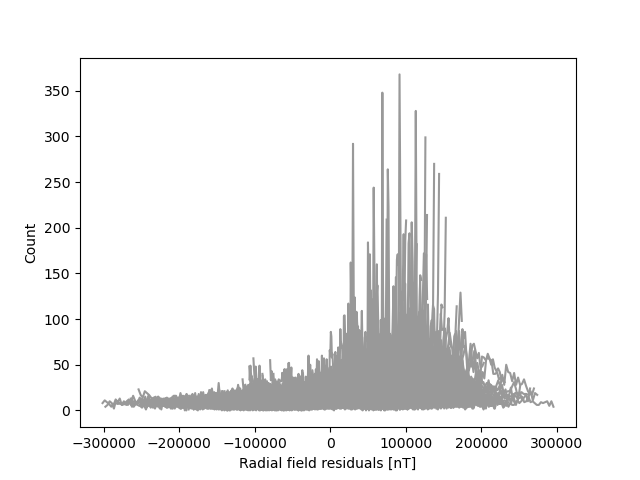

In [89]:
N_sim = 1000
core.target_var = np.max(C_Br_model)
#core.target_var = np.var(core.data)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        s_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = True, solve_cho = True)

In [90]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [158]:
core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


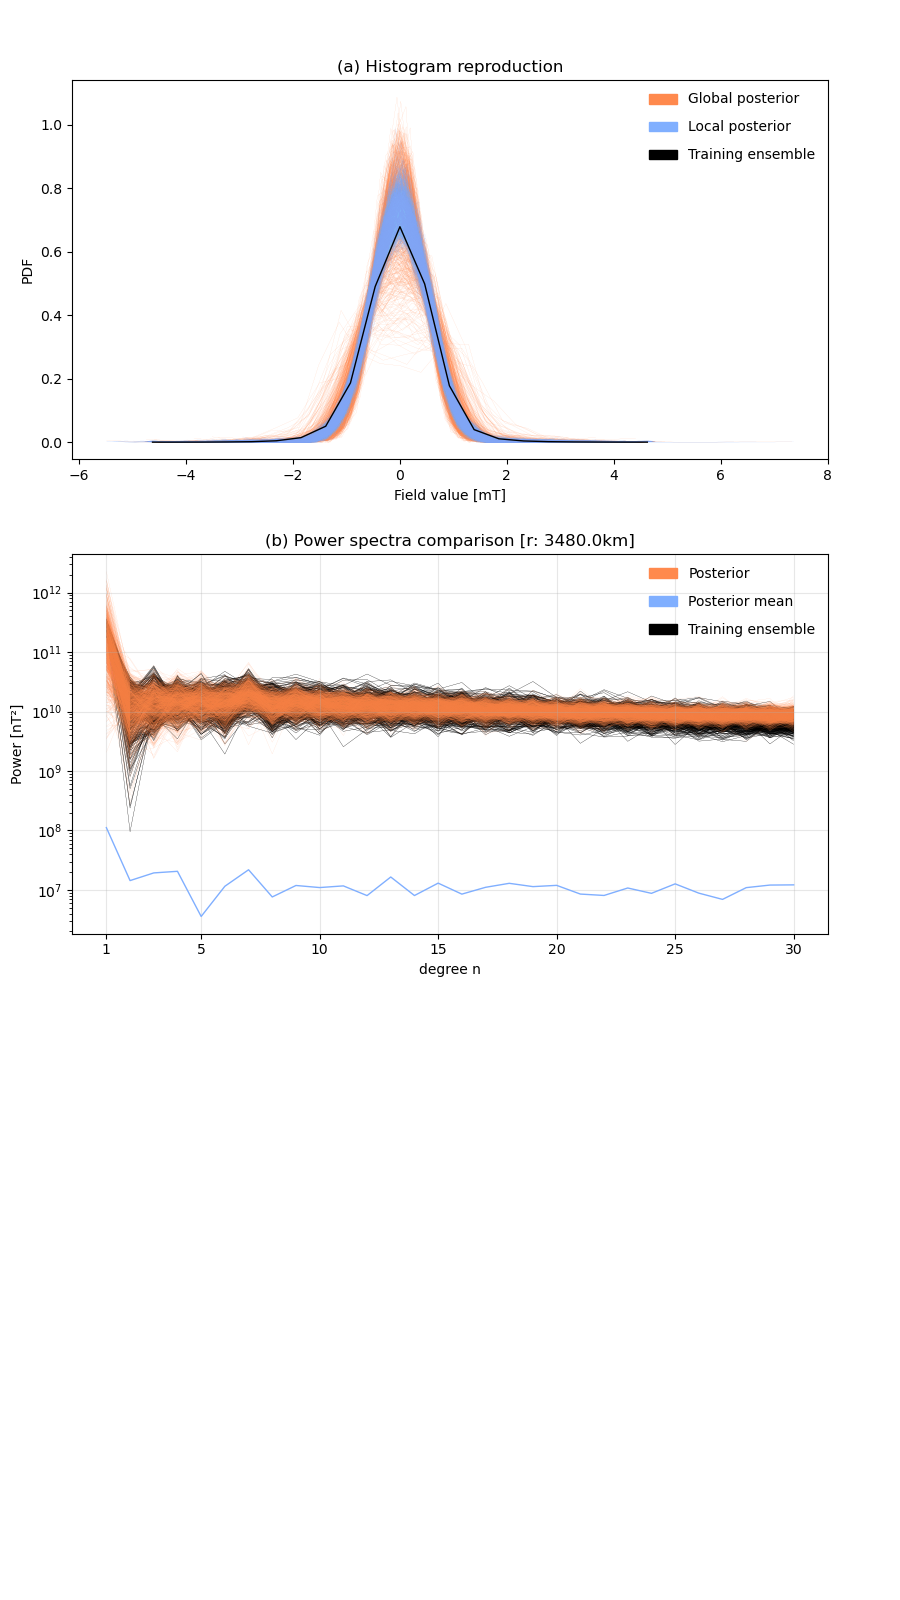

In [374]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, spec_lwidth = 0.05, label_fontsize = "medium",
                              res_use = False, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 21, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "core_sh30_ens", save_dpi = 300)

In [177]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Fit to covariance in sim
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  30
N_SH_secondary:        None
sim_type:              core_ens
grid_zero:             (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:        (31,), Max/Min: 0.10 / 0.01
grid_shape:            (2,), Max/Min: 61.00 / 31.00
grid_w:                (1891,), Max/Min: 0.10 / 0.01
grid_radial:           (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:            (1891,), Max/Min: 175.63 / 4.37
grid_phi:              (1891,), Max/Min: 354.10 / 0.00
grid_N:                1891
grid_nmax:             30
r_grid:                3480.0
grid:                  (1891, 2)
sph_d:                 (1891, 1891)
lon:                   (1891,), Max/Min: 354.10 

In [307]:
list_coord = np.array([[0,2], [-30,30], [45,-45], [70,-170]])
list_coord[:,0] = 90 - list_coord[:,0]
list_coord[:,1][list_coord[:,1]<0.0] = 360 + list_coord[:,1][list_coord[:,1]<0.0]
print(list_coord)

[[ 90   2]
 [120  30]
 [ 45 315]
 [ 20 190]]


In [302]:
m_coord_sph = np.hstack((90 - core.lat.reshape(-1,1), core.lon.reshape(-1,1)))

print(m_coord_sph)

[[  4.37398628   0.        ]
 [  4.37398628   5.90163934]
 [  4.37398628  11.80327869]
 ...
 [175.62601372 342.29508197]
 [175.62601372 348.19672131]
 [175.62601372 354.09836066]]


In [303]:
idx_min = np.sum(np.abs(m_coord_sph - list_coord[2]),axis=1).argmin()

In [304]:
idx_min

480

In [305]:
m_coord_sph[idx_min]

array([ 44.29310431, 312.78688525])

In [321]:
list_coord = np.array([[0,2], [-30,30], [45,-45], [70,-170]])
list_coord[:,0] = 90 - list_coord[:,0]
list_coord[:,1][list_coord[:,1]<0.0] = 360 + list_coord[:,1][list_coord[:,1]<0.0]

m_coord_sph = np.hstack((90 - core.lat.reshape(-1,1), core.lon.reshape(-1,1)))

idx_min = []
for coord in list_coord:
    idx_min.append(np.sum(np.abs(m_coord_sph - coord),axis=1).argmin())
    
print(idx_min)

m_hists_coord = m_coord_sph[idx_min]

m_hists = core.m_DSS[idx_min,:]

[915, 1225, 480, 215]


In [315]:
list_coord.shape

(4, 2)

In [318]:
left=0.08
bottom=0.12
right=0.92
top=0.95
wspace = 0.2
hspace=0.25

<IPython.core.display.Javascript object>


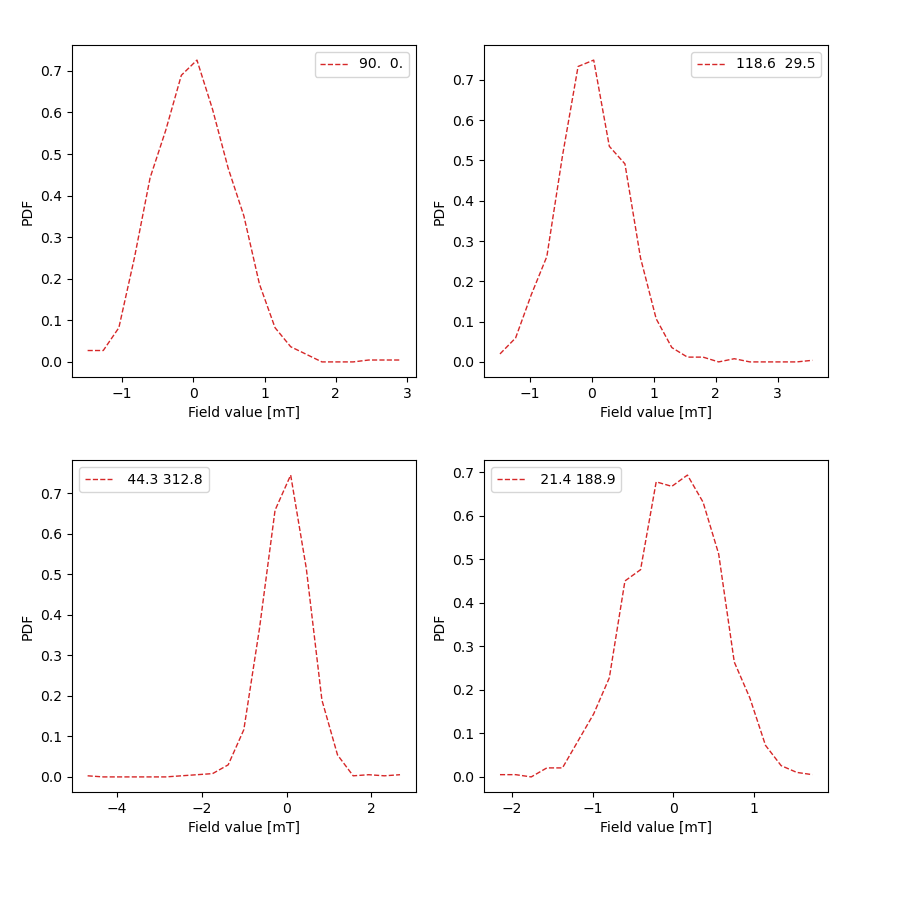

In [333]:
m_hists_scale = m_hists*10**(-6)

tile_size_row = 2
tile_size_column = 2

label_fontsize = 10

fig = plt.figure(figsize=(9,9)) # Initiate figure with constrained layout
# Generate ratio lists
h_ratio = [1]*tile_size_row
w_ratio = [1]*tile_size_column
gs = fig.add_gridspec(tile_size_row, tile_size_column, height_ratios=h_ratio, width_ratios=w_ratio) # Add x-by-y grid

for i in np.arange(0,list_coord.shape[0]):

    ax = fig.add_subplot(gs[i])
    
    y,binEdges=np.histogram(m_hists_scale[i,:],bins=21,density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])    
    ax.plot(bincenters, y, '-', color = "C3", 
            label='{}'.format(str(np.round(m_hists_coord[i,:],decimals=1))).lstrip('[').rstrip(']'), 
            linestyle = "dashed", linewidth = 1)

    #ax.set_title('test')
    #ax.annotate("test", (0.05, 0.5), xycoords='axes fraction', va='center', fontsize = label_fontsize)
    ax.set_xlabel("Field value [mT]")
    ax.set_ylabel("PDF")
    ax.legend(loc='best', fontsize = label_fontsize)
    

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

<IPython.core.display.Javascript object>


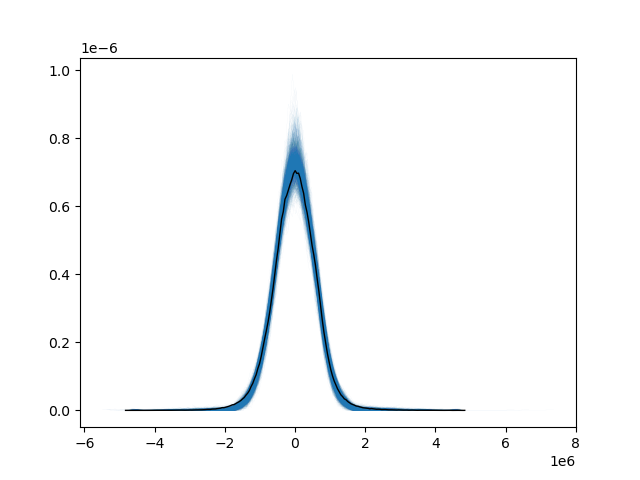

In [344]:
plt.figure()
for i in np.arange(0,len(core.m_DSS)):
    y,binEdges=np.histogram(core.m_DSS[i,:],bins=21,density=True)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])    
    plt.plot(bincenters, y, '-', color = "C0", linewidth = 0.01)

ti_hist_data = np.ravel(core.m_core_ens)
ti_hist_data = ti_hist_data[0.5*np.max(np.abs(ti_hist_data))>np.abs(ti_hist_data)]
y,binEdges=np.histogram(ti_hist_data,bins=201,density=True)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])    
plt.plot(bincenters, y, '-', color = "k", linewidth = 1)
plt.show()

In [93]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


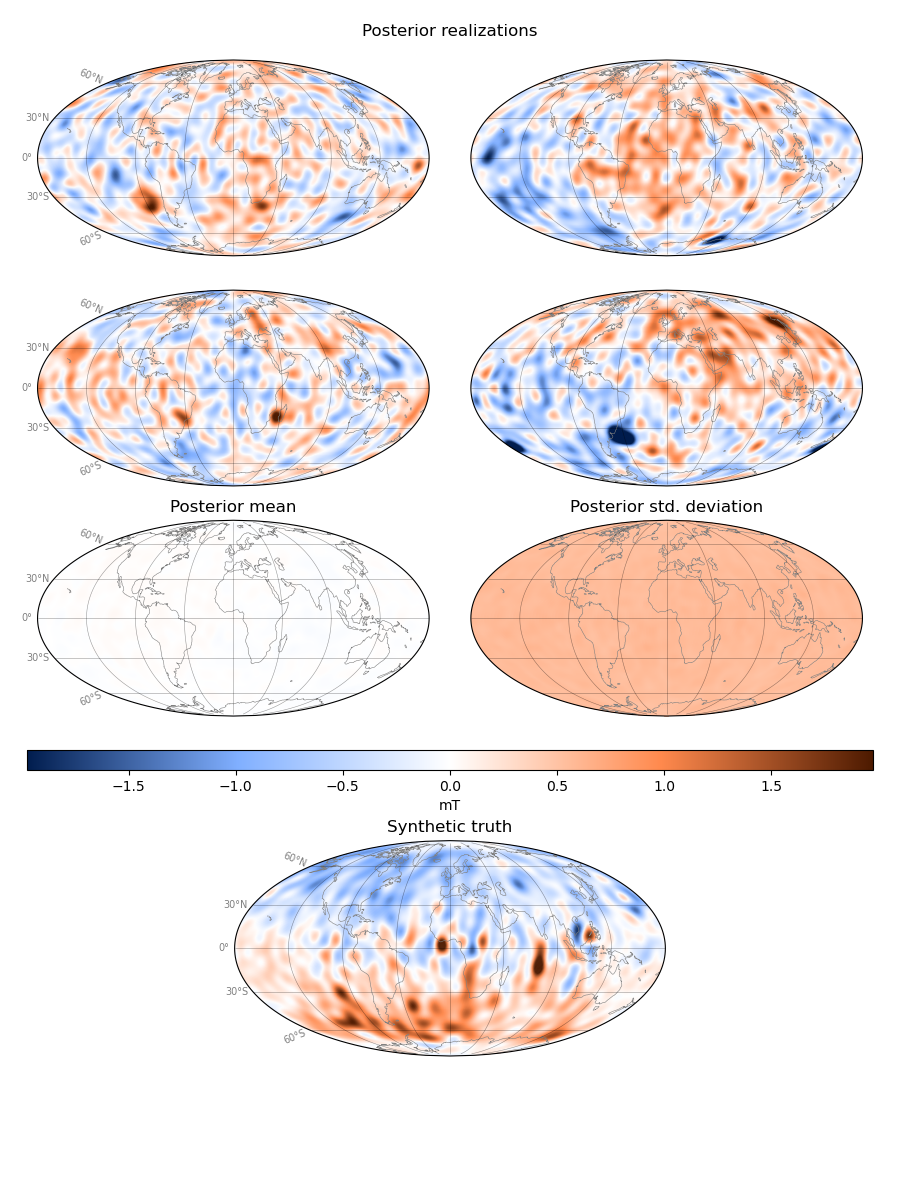

In [94]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "core_sh30_newTI", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


<IPython.core.display.Javascript object>


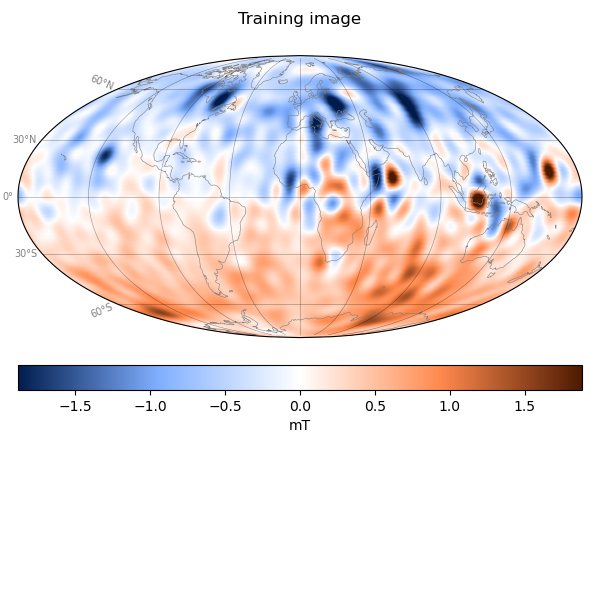

In [79]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
training_image = core.B_ensemble[:,0].copy()

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=training_image, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Training image', point_size=1,
                savefig = False, save_dpi = 100, save_string ="core_sh30_synth_TI",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)